In [35]:
import numpy as np
import matplotlib as mpl
from numpy import float32, float64
import matplotlib.pyplot as plt
from functools import partial
import itertools
from collections import namedtuple

In [36]:
label_font = 12
markersize = 8

In [37]:
def get_a_ij(i: int, j: int, n: int):
    if i == j:
        return 2.0 + (float64(i) / float64(n)) ** 2.0
    elif j == i - 1 or j == i + 1:
        return -1.0
    elif (i == 0 and j == n - 1) or (i == n - 1 and j == 0):
        return -1.0
    else:
        return 0.0


def get_matrix_a(n: int) -> np.array:
    a = np.zeros((n, n))
    from_0_to_n = [i for i in range(n)]
    for i, j in itertools.product(from_0_to_n, from_0_to_n):
        a[i, j] = get_a_ij(i, j, n)
    return a


def get_f(n: int) -> np.array:
    def get_f_i(i):
        return (1.0 + n**2.0 * np.sin(np.pi / n) ** 2.0) * np.sin(
            (2.0 * np.pi * i) / float64(n)
        )

    return np.array([get_f_i(i) for i in range(n)])

In [38]:
# Векторные и подчиненные им матричные нормы
def vec_norm_max(vector: np.array):
    # |v|_1 = max(abs(v_i))
    return np.abs(vector).max()


def vec_norm_sum(vector: np.array):
    # |v|_2 = sum(abs(v_i))
    return np.abs(vector).sum()

def vec_norm_euclid(vector: np.array):
    return np.sqrt((vector ** 2.0).sum())


def row_sum_norm(matrix: np.array):
    # |A|_1 = max( sum(a_ij) for j ) over 1 <= i <= n
    return np.sum(np.abs(matrix), axis=1).max()


def column_sum_norm(matrix: np.array):
    # |A|_2 = max( sum(a_ij) for i ) over 1 <= j <= n
    return np.sum(np.abs(matrix), axis=0).max()


def spectral_norm(matrix: np.array):
    matrix_h = matrix.conj().T
    eigenvalues = np.linalg.eigvals(np.matmul(matrix_h, matrix))
    return np.sqrt(eigenvalues.max())


def mu(matrix_a: int, norm):
    inv_matrix_a = np.linalg.inv(matrix_a)
    norm_a = norm(matrix_a)
    norm_inv_a = norm(inv_matrix_a)
    return norm_a * norm_inv_a


In [39]:
EPS = 10e-8

def lup(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise AttributeError("Только квадратные матрицы подходят для LUP")

    n = matrix.shape[0]
    p = np.identity(n)
    
    for i in range(0, n - 1):

        max_idx = i
        for k in range(i + 1, n):
            # Найдем максимальный опорный элемент в столбце
            if abs(matrix[k][i]) > abs(matrix[max_idx][i]):
                max_idx = k
        
        if abs(matrix[max_idx][i]) <= EPS:
            raise ArithmeticError("Опорный элемент равен нулю")

        if max_idx != i:
            matrix[[i, max_idx]] = matrix[[max_idx, i]]
            p[[i, max_idx]] = p[[max_idx, i]]

        for j in range(i + 1, n):
            matrix[j][i] /= matrix[i][i]
            for k in range(i + 1, n):
                matrix[j][k] -= matrix[j][i] * matrix[i][k]

        l = np.zeros(matrix.shape)
        for i in range(n):
            for j in range(n):
                if j < i:
                    l[i][j] = matrix[i][j]
                if j == i:
                    l[i][j] = 1

        u = np.zeros(matrix.shape)
        for i in range(n):
            for j in range(n):
                if j >= i:
                    u[i][j] = matrix[i][j]
    return l, u , p

In [40]:
def lower_solve(l: np.array, f: np.array):
    assert l.ndim == 2 and l.shape[0] == l.shape[1]
    dim = l.shape[0]

    x = np.zeros(dim)
    for i in range(dim):
        tmp = f[i]
        for j in range(i):
            tmp -= l[i, j] * x[j]
        x[i] = tmp / l[i, i]

    return x


def upper_solve(u: np.array, f: np.array):
    # Solve Ux = f, where U is upper triangular
    assert u.ndim == 2 and u.shape[0] == u.shape[1]
    dim = u.shape[0]

    x = np.zeros(dim)
    for i in range(dim - 1, -1, -1):
        tmp = f[i]
        for j in range(i + 1, dim):
            tmp -= u[i, j] * x[j]
        x[i] = tmp / u[i, i]

    return x


def lu_solve(l, u, f):
    # Ax = f, where A = LU
    # L(Ux) = f, Ux = y <=> y = Ux
    y = lower_solve(l, f)
    x = upper_solve(u, y)
    return x

In [41]:
def lup_solve(a: np.array, f: np.array):
    l, u, p = lup(a)
    z = np.matmul(p, f)
    x = lu_solve(l, u, z)
    return x

In [42]:
def simple_iter(
    a: np.array,
    f: np.array,
    tau: float64,
    eps: float64,
    norm = vec_norm_euclid,
    max_iter: int = 1000000,
) -> np.array:
    assert a.ndim == 2
    assert f.ndim == 1
    assert a.shape[0] == a.shape[1]
    assert a.shape[0] == f.shape[0]

    dim = a.shape[0]
    tau_f = f * tau
    cur = np.zeros(dim)
    b = np.eye(dim) - tau * a
    err_list = []

    for i in range(max_iter):
        cur = np.matmul(b, cur) + tau_f
        err = f - np.matmul(a, cur)
        norm_err = norm(err)
        err_list.append(norm_err)

        if norm_err < eps:
            return (cur, err_list)

    raise RuntimeWarning("Простая итерация расходится")

In [43]:
Gershgorin = namedtuple("Gershgorin", "a r")


def get_gershgorin(a: np.array):
    assert a.ndim == 2
    assert a.shape[0] == a.shape[1]

    circles = []
    for i, row in enumerate(a):
        a_ii = a[i, i]
        r_i = np.abs(row).sum() - a_ii
        circles.append(Gershgorin(a_ii, r_i))

    return circles

In [44]:
 # Коэффициенты полинома
def compute_ch_poly(a: np.array, y0: np.array):
    assert a.ndim == 2
    assert y0.ndim == 1
    assert a.shape[0] == a.shape[1]
    assert a.shape[0] == y0.shape[0]

    dim = a.shape[0]
    y_matrix = np.zeros((dim, dim))
    y = y0

    for i in range(dim - 1, -1, -1):
        y_matrix[:, i] = y
        y = np.matmul(a, y)

    ps = lup_solve(y_matrix, y)

    return np.concatenate([np.ones(1), -1.0 * ps])

In [45]:
def plot_gershgorin(ax: plt.Axes, eigvals: np.array, circles: list, **kwargs):
    # https://github.com/WenqiJiang/matplotlib-templates/blob/master/plot/plot.py

    max_x = 0.0
    min_x = 0.0

    for a, r in circles:
        circle = plt.Circle((a.real, 0.0), r, **kwargs)
        ax.add_patch(circle)

        max_x = max(max_x, a.real + r)
        min_x = min(min_x, a.real - r)

    max_dim = max(abs(max_x), abs(min_x))
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((-max_dim, max_dim))

    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    ax.grid(True, which="both")
    ax.set_xlabel("$Re(\lambda)$", fontsize=label_font)
    ax.set_ylabel("$Im(\lambda)$", fontsize=label_font)

    plt.rcParams.update({"figure.autolayout": True})

    ys = np.zeros(eigvals.shape[0])
    ax.scatter(eigvals, ys, color="red")

In [46]:
def plot_function(ax: plt.Axes, xs: np.array, ys: list, **kwargs):
    # https://github.com/WenqiJiang/matplotlib-templates/blob/master/plot/plot.py

    plot = ax.plot(xs, ys, **kwargs)

    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    ax.grid(True, which="both")
    ax.set_xlabel("$x$", fontsize=label_font)
    ax.set_ylabel("$y$", fontsize=label_font)

    plt.rcParams.update({"figure.autolayout": True})
    return plot

In [47]:
def newton_solve(x0, f, der, eps: float64, max_iter=1000000) -> np.array:
    cur = x0

    for i in range(max_iter):
        delta = f(cur) / der(cur)
        cur -= delta

        if abs(delta) < eps:
            return cur

    raise RuntimeWarning(
        "Метод Ньютона не сходится")
    

In [48]:
def get_roots(coeffs: np.array, stpts: np.array, eps):
    def f(x):
        return np.polyval(coeffs, x)

    def der(x):
        return np.polyval(np.polyder(coeffs), x)

    return np.array([newton_solve(st, f, der, eps=eps) for st in stpts])

In [49]:
 def print_sep():
    print("\n----\n")

In [50]:
def do_solve_with_tau(
    a, f, eps, tau, comment="any", norm = vec_norm_euclid
):
    (solution, errs) = simple_iter(a, f, tau, eps)
    exact_sol = np.linalg.solve(a, f)
    delta = solution - exact_sol

    print_sep()
    print(f"Solution with tau = {tau} ({comment}):")
    print(solution)
    print(f"Norm of |exact - sol| = {norm(delta)}")

    return errs

In [51]:
n = 6  # size on system
a = get_matrix_a(n)
f = get_f(n)

In [52]:
print(f'a = \n{a}')
print(f'f = \n{f}')

a = 
[[ 2.         -1.          0.          0.          0.         -1.        ]
 [-1.          2.02777778 -1.          0.          0.          0.        ]
 [ 0.         -1.          2.11111111 -1.          0.          0.        ]
 [ 0.          0.         -1.          2.25       -1.          0.        ]
 [ 0.          0.          0.         -1.          2.44444444 -1.        ]
 [-1.          0.          0.          0.         -1.          2.69444444]]
f = 
[ 0.00000000e+00  8.66025404e+00  8.66025404e+00  1.22464680e-15
 -8.66025404e+00 -8.66025404e+00]


In [53]:
coeffs = compute_ch_poly(a, np.ones(n))

(0.0, 4.694444444444445)

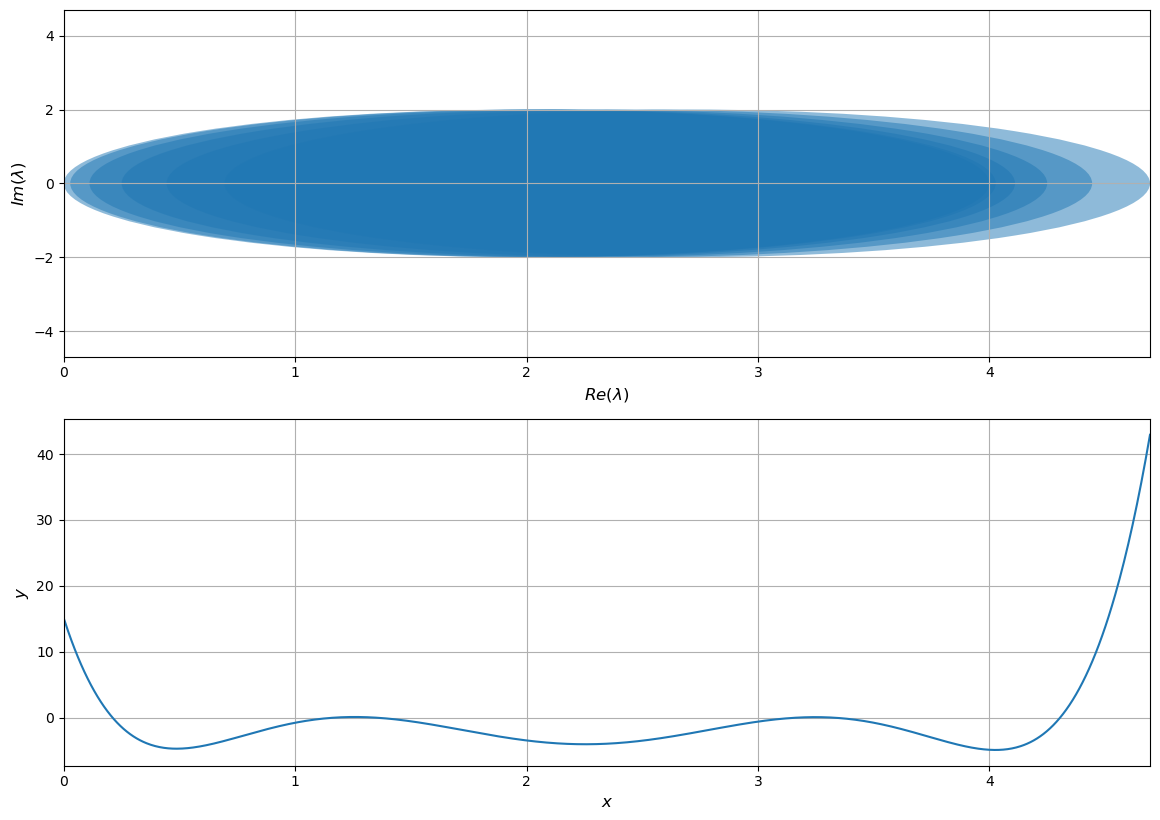

In [56]:
# Plot polynomial to find starting points for newton's method
fig, (ax_gersh, ax_poly) = plt.subplots(2, 1, figsize=(11.7, 8.3))
plot_gershgorin(ax_gersh, np.array([]), get_gershgorin(a), alpha=0.5)
left, right = ax_gersh.get_xlim()
xs = np.linspace(left, right, 1000)
plot_function(ax_poly, xs, np.polyval(coeffs, xs))
ax_poly.set_xlim(ax_gersh.get_xlim())

In [57]:
 eps = 1e-6

# Шаг 2. Подсчет собственных значений
for i, (c, r) in enumerate(get_gershgorin(a)):
    print(f"|lambda_{i}' - {c}| <= {r}")

# Метод Крылова
krylov_eigvals = get_roots(coeffs, [0.0, 1.0, 1.5, 3.0, 3.5, 4.25], eps=eps)
exact_eigvals = np.linalg.eigvals(a)
krylov_eigvals.sort()
exact_eigvals.sort()

print("\n-- Собственные значения (Крылов) --\n")
for i, v in enumerate(krylov_eigvals):
    print(f"lambda_{i} = {v}")

print("\n-- Собственные значения (Numpy) --\n")
for i, v in enumerate(exact_eigvals):
    print(f"lambda_{i} = {v}")

tau_any = 0.20
tau_opt_krylov = 2.0 / (krylov_eigvals.min() + krylov_eigvals.max())
tau_opt_numpy = 2.0 / (exact_eigvals.min() + exact_eigvals.max())

print_sep()
print(f"tau_opt_numpy\t= {tau_opt_numpy}")
print(f"tau_opt_krylov\t= {tau_opt_krylov}")

bound_solve = partial(do_solve_with_tau, a=a, f=f, eps=eps)

errs_some = bound_solve(tau=tau_any, comment="some value")
errs_krylov = bound_solve(tau=tau_opt_krylov, comment="opt with krylov")
errs_numpy = bound_solve(tau=tau_opt_numpy, comment="opt with numpy")

|lambda_0' - 2.0| <= 2.0
|lambda_1' - 2.0277777777777777| <= 2.0
|lambda_2' - 2.111111111111111| <= 1.9999999999999996
|lambda_3' - 2.25| <= 2.0
|lambda_4' - 2.4444444444444446| <= 2.0
|lambda_5' - 2.6944444444444446| <= 2.0

-- Собственные значения (Крылов) --

lambda_0 = 0.21074228926813401
lambda_1 = 1.1723536556934515
lambda_2 = 1.3444997499925933
lambda_3 = 3.172098845043765
lambda_4 = 3.322122246700257
lambda_5 = 4.305960991079286

-- Собственные значения (Numpy) --

lambda_0 = 0.21074228926852
lambda_1 = 1.172353655693412
lambda_2 = 1.344499749992459
lambda_3 = 3.1720988450437133
lambda_4 = 3.3221222467005886
lambda_5 = 4.3059609910790835

----

tau_opt_numpy	= 0.44280083854569274
tau_opt_krylov	= 0.4428008385457108

----

Solution with tau = 0.2 (some value):
[ 5.3478266  12.93976584 12.23088945  4.22074719 -2.73420791 -2.24411219]
Norm of |exact - sol| = 4.551685315972811e-06

----

Solution with tau = 0.4428008385457108 (opt with krylov):
[ 5.34782662 12.93976583 12.23088947 

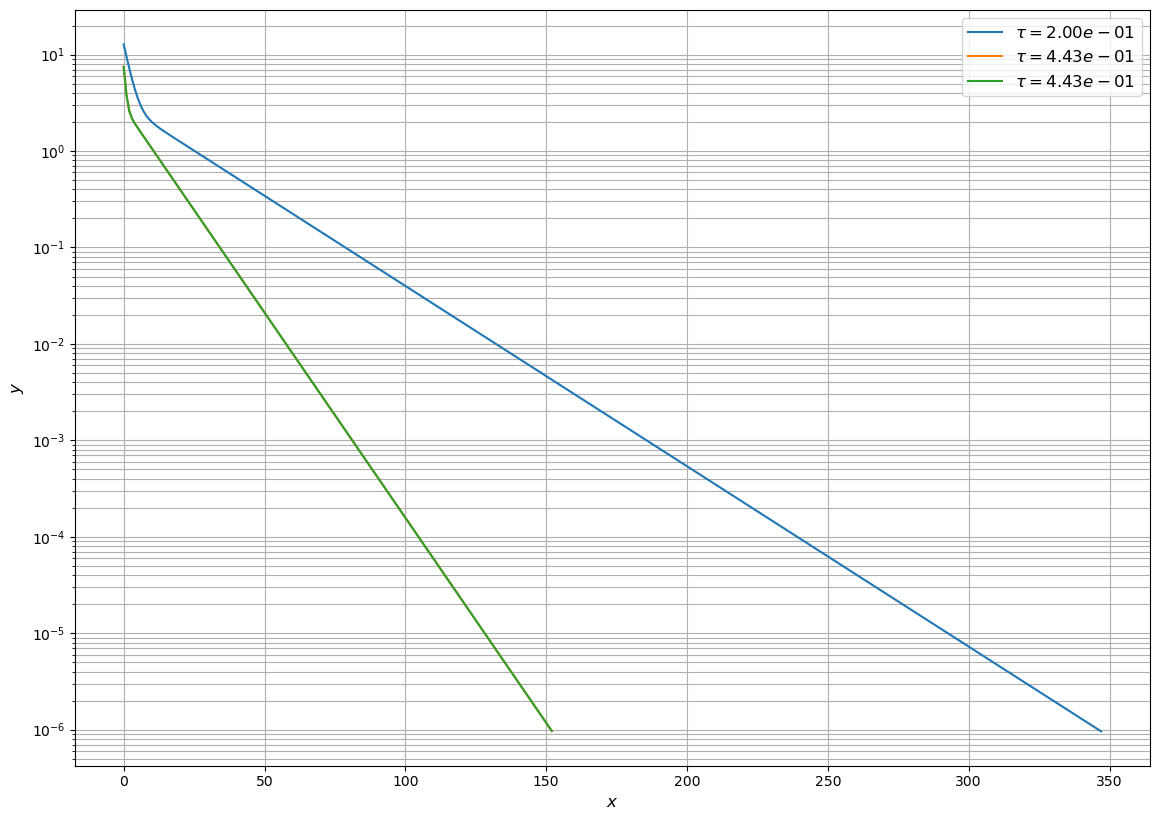

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(11.7, 8.3))

ax.set_yscale('log')
plot_some = plot_function(ax, np.arange(0, len(errs_some)), errs_some)
plot_krylov = plot_function(ax, np.arange(0, len(errs_krylov)), errs_krylov)
plot_numpy = plot_function(ax, np.arange(0, len(errs_numpy)), errs_numpy)

ax.legend([plot_some[0], plot_krylov[0], plot_numpy[0]],
          [f'$\\tau = {tau_any:1.2e}$',
           f'$\\tau = {tau_opt_krylov:1.2e}$',
           f'$\\tau = {tau_opt_numpy:1.2e}$'],
          loc='upper right', fontsize=label_font)